<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TensorFlow%20Core/Tutorials/Images/Visualizing%20Convolutional%20Neural%20Network%20Layers/Vizualizing_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Methods of Vizualization 

* Preliminary Methods
  
  * Model Summary
  * Plot Model Architecture
  * Visualize Feature Maps
  * Visualize Filters
  * Heatmap Vizualization

* Activation Based Methods

  * Maximal Activation
  * Image Occlusion

* Gradient Based Methods

  * Saliency Maps
  * Gradient Based Class Activation Map (Grad CAM)

* Framework Based Vizualization

  * TensorBoard
  * What IF Tool
  

In [32]:
!pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [127]:
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import *
from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [0]:
X_train, X_test = X_train.reshape(X_train.shape +  (1,)) / 255.0, X_test.reshape(X_test.shape+(1,)) / 255.0

In [0]:
def make_model():
  model = tf.keras.Sequential([
                              Conv2D(256, (3,3), activation=tf.nn.relu, input_shape=X_train.shape[1:]),
                              BatchNormalization(),
                              MaxPooling2D(2,2),
                              Conv2D(128, (3,3), activation=tf.nn.relu),
                              BatchNormalization(),
                              MaxPooling2D(2,2),
                              Conv2D(64, (3,3), activation=tf.nn.relu),
                              BatchNormalization(),
                              MaxPooling2D(2,2),
                              Flatten(),
                              Dense(128, activation = tf.nn.relu),
                              Dropout(0.3),
                              Dense(10, activation=tf.nn.softmax)
  ])
  model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
  return model

In [0]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().batch(64).shuffle(5000).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [39]:
with strategy.scope():
  model = make_model()
  history = model.fit(train_dataset, 
                      epochs=20, 
                      validation_data=test_dataset, 
                      verbose=1,
                      callbacks = [
                                  tf.keras.callbacks.TensorBoard(log_dir='logs/'),
                                  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1),
                                  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=2,verbose=1),
                                  tf.keras.callbacks.ModelCheckpoint("checkpoints/",save_best_only=True,monitor='val_loss',verbose=1,save_weights_only=True)
                      ])

Epoch 1/20
    938/Unknown - 31s 33ms/step - loss: 0.4889 - accuracy: 0.8243
Epoch 00001: val_loss improved from inf to 0.42597, saving model to checkpoints/
938/938 [==============================] - 35s 37ms/step - loss: 0.4889 - accuracy: 0.8243 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
936/938 [============================>.] - ETA: 0s - loss: 0.3371 - accuracy: 0.8762
Epoch 00002: val_loss did not improve from 0.42597
938/938 [==============================] - 29s 31ms/step - loss: 0.3372 - accuracy: 0.8762 - val_loss: 0.4365 - val_accuracy: 0.8443
Epoch 3/20
937/938 [============================>.] - ETA: 0s - loss: 0.2929 - accuracy: 0.8933
Epoch 00003: val_loss improved from 0.42597 to 0.33754, saving model to checkpoints/
938/938 [==============================] - 30s 32ms/step - loss: 0.2929 - accuracy: 0.8934 - val_loss: 0.3375 - val_accuracy: 0.8716
Epoch 4/20
936/938 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.9032
Epoch 00004

In [128]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 256)       2560      
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 128)       295040    
_________________________________________________________________
batch_normalization_7 (Batch (None, 11, 11, 128)       512       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 3, 64)         

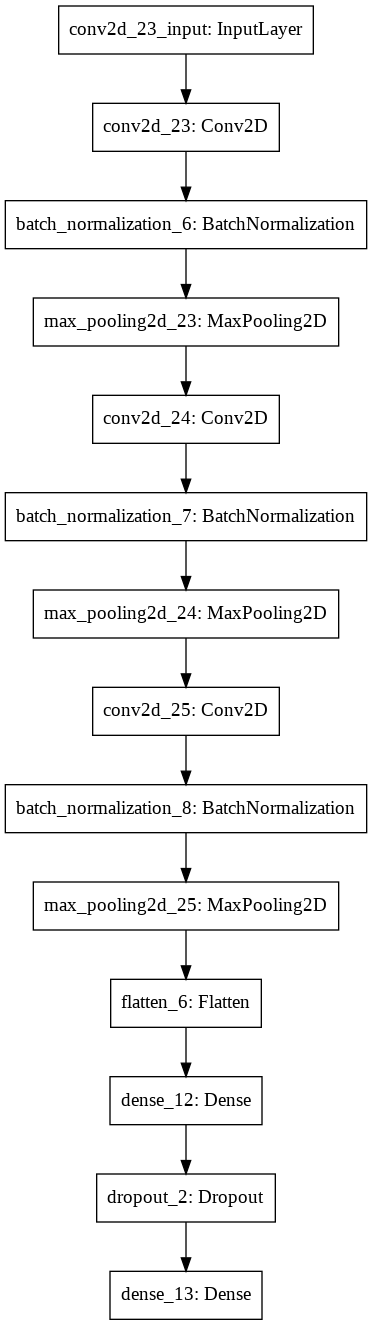

In [129]:
plot_model(model)

#### 3. Vizualizing Feature Maps

In [0]:
successive_outputs = [layer.output for layer in model.layers]
vizualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

In [89]:
vizualization_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23_input (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 26, 26, 256)       2560      
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 128)       295040    
_________________________________________________________________
batch_normalization_7 (Batch (None, 11, 11, 128)       512       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 128)         0   

In [90]:
x = X_test[0]
x = x.reshape((1,) + x.shape)
print(x.shape)

(1, 28, 28, 1)


In [0]:
successive_feature_maps = vizualization_model.predict(x)

In [92]:
for l, f in zip(model.layers,successive_feature_maps):
  print(l.name,":",f.shape)

conv2d_23 : (1, 26, 26, 256)
batch_normalization_6 : (1, 26, 26, 256)
max_pooling2d_23 : (1, 13, 13, 256)
conv2d_24 : (1, 11, 11, 128)
batch_normalization_7 : (1, 11, 11, 128)
max_pooling2d_24 : (1, 5, 5, 128)
conv2d_25 : (1, 3, 3, 64)
batch_normalization_8 : (1, 3, 3, 64)
max_pooling2d_25 : (1, 1, 1, 64)
flatten_6 : (1, 64)
dense_12 : (1, 128)
dropout_2 : (1, 128)
dense_13 : (1, 10)


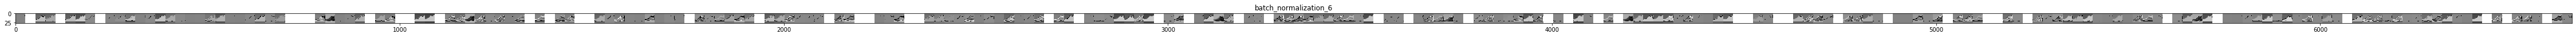

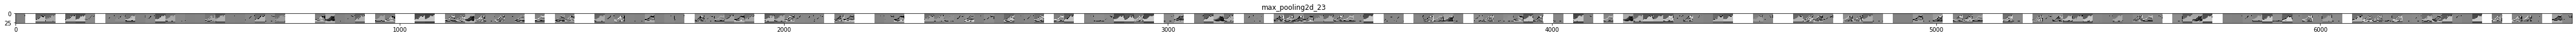

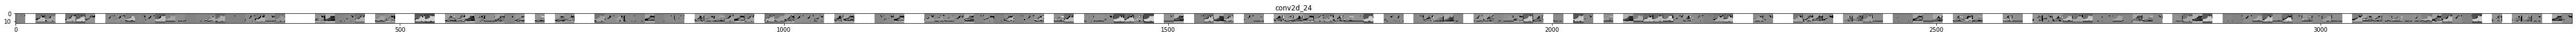

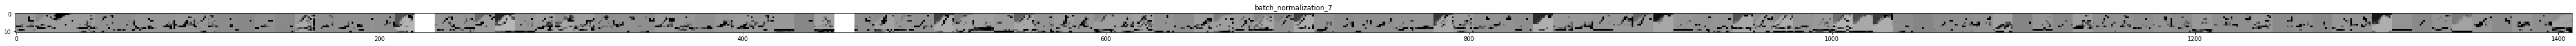

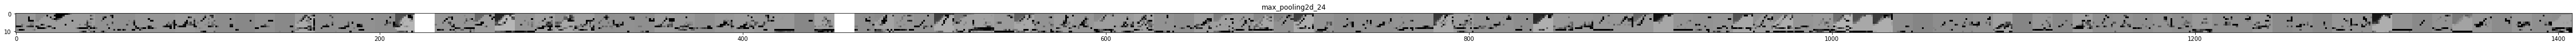

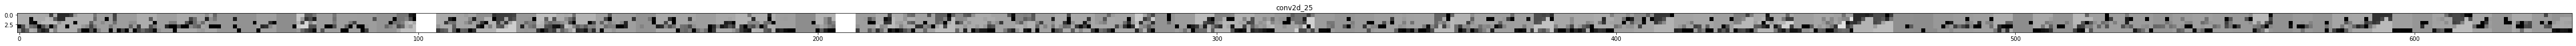

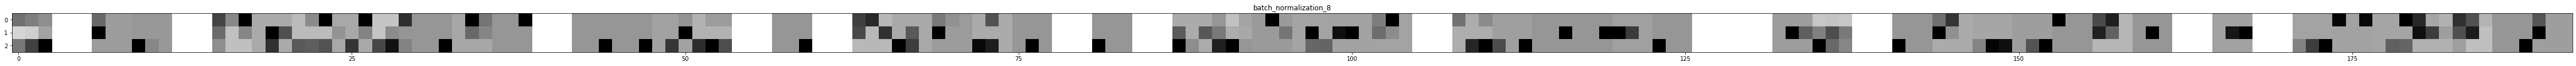

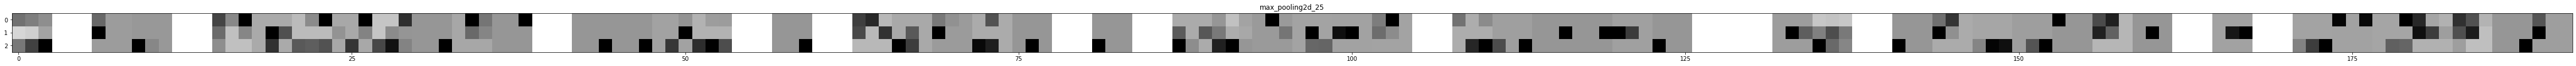

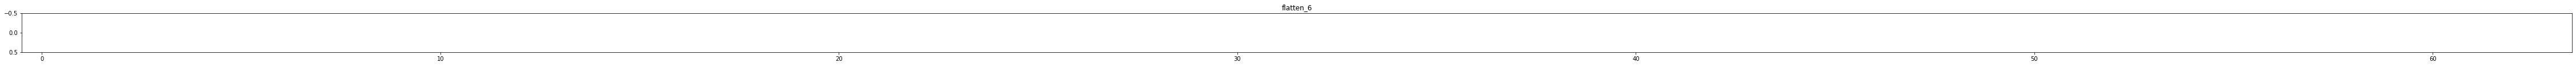

In [131]:
for layer_name, feature_map in zip(model.layers[1:],successive_feature_maps):
  if len(feature_map.shape)==4:
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]

    display_grid = np.zeros((size, size*n_features))

    for i in range(n_features):
      x = feature_map[0,:,:,i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:,i*size:(i+1)*size] = x
    scale = 80/n_features
    plt.figure(figsize=(scale*n_features, scale))
    plt.title(layer_name.name)
    plt.grid(False)
    plt.imshow(display_grid, cmap=plt.cm.binary, interpolation='nearest', aspect='auto')
    plt.show()

#### 4. Vizualizing Filters

In [97]:
for i, name in enumerate(model.layers):
  print(i,":",name.name)

0 : conv2d_23
1 : batch_normalization_6
2 : max_pooling2d_23
3 : conv2d_24
4 : batch_normalization_7
5 : max_pooling2d_24
6 : conv2d_25
7 : batch_normalization_8
8 : max_pooling2d_25
9 : flatten_6
10 : dense_12
11 : dropout_2
12 : dense_13


In [0]:
filters, biases = model.layers[6].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, n_features, ix = filters.shape[-1], filters.shape[2], 1

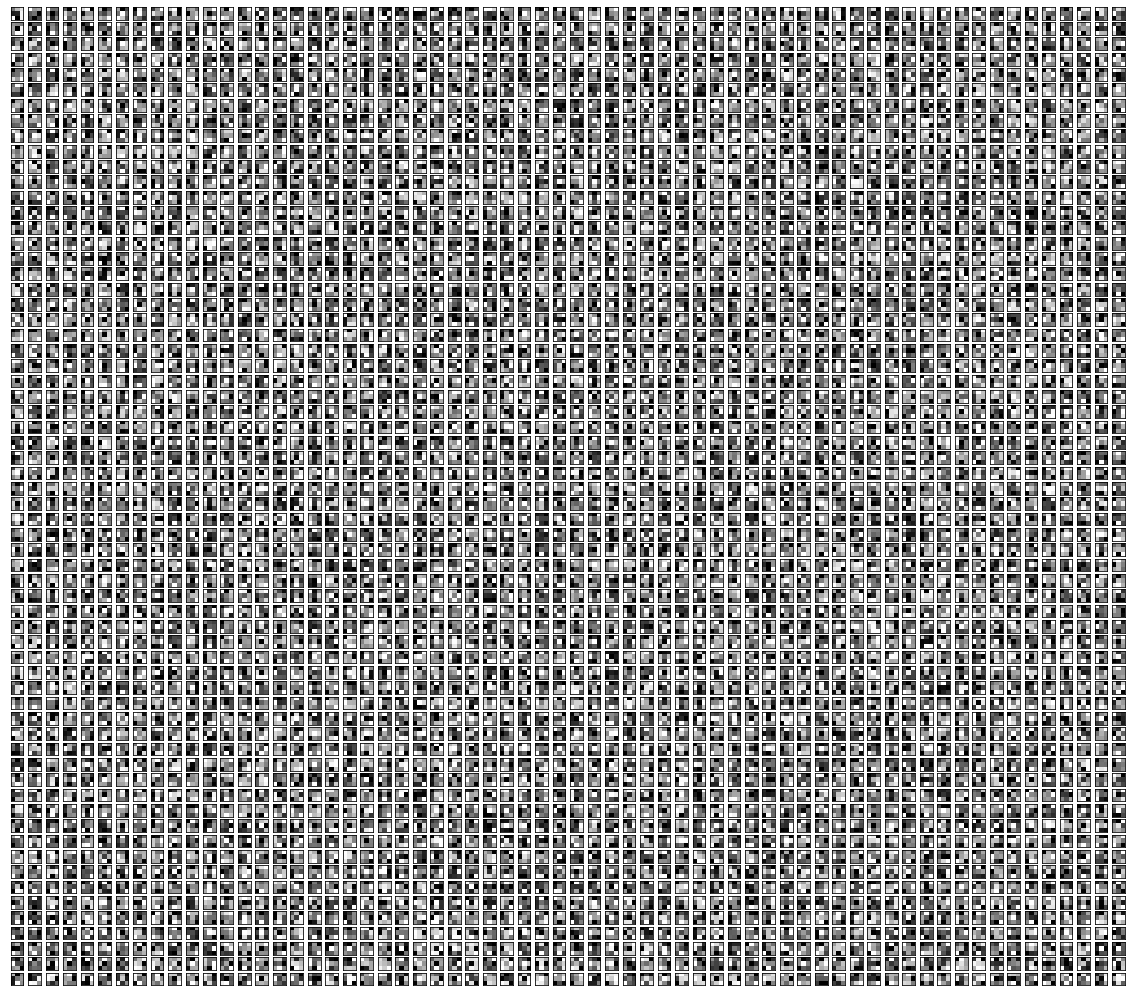

In [126]:
n_filters, ix = 64, 1
plt.figure(figsize=(20,18))
for i in range(n_filters):
	f = filters[:, :, :, i]
	for j in range(n_features):
		ax = plt.subplot(n_filters, n_features, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
plt.show()